# Reducing variance by removing between categories variance  
When we speak about total variance we assume within group variance and the variance between groups. Hovewer if we try to split each group by certain categories (os, country, user segment etc) we will see that there is variance between and within user segments wich contributes to within group variance.  
This (between user segments) variance, however, is not very useful and only increase within group variance. Fortunetely, we can get rid from it by simple adjustment:  
Value adjusted = value * group mean / segment mean

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import json
import matplotlib.pyplot as plt

from google.cloud import storage
from google.cloud import bigquery

In [2]:
bigquery_client = bigquery.Client.from_service_account_json('../../credentials/data-analysis-sql-309220-6ce084250abd.json')
storage_client = storage.Client.from_service_account_json('../../credentials/data-analysis-sql-309220-6ce084250abd.json')

### Read data

In [52]:
query = '''
SELECT date
    , `group` AS `group`
    , country
    , platform
    , amount
FROM `data-analysis-sql-309220.synthetic.payments`
LIMIT 10000
'''


query_job = bigquery_client.query(query)
df = query_job.to_dataframe()
df.head()

,date,group,country,platform,amount
0,2021-03-02,experimental,DE,web,9.96
1,2021-03-02,experimental,DE,ios,4.12
2,2021-03-02,control,DE,web,24.28
3,2021-03-02,experimental,DE,ios,27.53
4,2021-03-02,control,DE,web,8.35


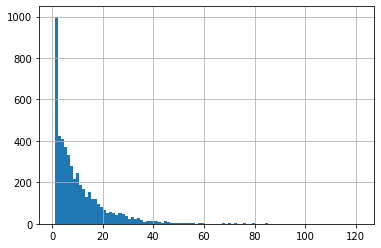

In [53]:
df.loc[df.group == 'experimental', 'amount'].hist(bins=100);

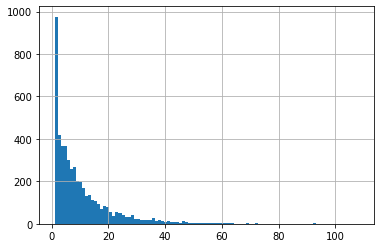

In [54]:
df.loc[df.group == 'control', 'amount'].hist(bins=100);

In [55]:
df.groupby('country')['amount'].mean()

country
DE    11.922600
FR    10.661533
IT     8.871289
UK     9.300000
Name: amount, dtype: float64

In [56]:
df.groupby('platform')['amount'].mean()

platform
android     9.807198
ios        12.658309
web         8.387113
Name: amount, dtype: float64

## Adjusting means

#### by country

In [57]:
# mean by groups
df_group_mean = df.groupby('group')['amount'].mean().reset_index().rename(columns={'amount': 'group_mean'})

# mean by country
df_country_platform_mean = df.groupby(['group', 'country', 'platform'])['amount'].mean().reset_index().rename(columns={'amount': 'country_platform_mean'})

In [58]:
df = df.merge(df_group_mean, how='left', on='group').merge(df_country_platform_mean, how='left', on=['group', 'country', 'platform'])

df.head()

,date,group,country,platform,amount,group_mean,country_platform_mean
0,2021-03-02,experimental,DE,web,9.96,10.350319,9.787069
1,2021-03-02,experimental,DE,ios,4.12,10.350319,15.542832
2,2021-03-02,control,DE,web,24.28,10.114852,10.976770
3,2021-03-02,experimental,DE,ios,27.53,10.350319,15.542832
4,2021-03-02,control,DE,web,8.35,10.114852,10.976770


In [59]:
df['amount_adj'] = df['amount'] * df['group_mean'] / df['country_platform_mean']

In [60]:
df.groupby('group').agg({'amount': ['mean', 'std'], 'amount_adj': ['mean', 'std']})

amount            amount_adj           
                   mean        std       mean        std
group                                                   
control       10.114852  10.688564  10.114852  10.181630
experimental  10.350319  10.740507  10.350319  10.231475

Although the variance drop is not that big in this particular eexample, it still alows to speed up conclusions.
When user segmentation is more advanced than suggested (by country and platform), improvement can be much better.